In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import shuffle
import cv2

## Data Importing and Preprocessing

### Declare variables

In [2]:
dataset_folder = './dataset/'

face_path  = dataset_folder + 'face'
nface_path = dataset_folder + 'nonface'
testing_face_path = dataset_folder + 'testing/face'
testing_nface_path = dataset_folder + 'testing/nonface'
img_ext = ['.jpg', '.png', 'jpeg', '.pgm', '.bmp', 'JPEG']

height, width = 128, 128

### Helper functions to get the path of the files

In [3]:
def read_face_files(file_path=face_path):
    face_list = []
    
    for f in glob.glob(file_path + '/**', recursive=True):
        
        if f[-4:] in img_ext:
            face_list.append(f)
    
    return face_list

def read_nonface_files(file_path=nface_path):
    
    nonface_list = []
    
    for f in glob.glob(file_path + '/**', recursive=True):
        
        if f[-4:] in img_ext:
            nonface_list.append(f)
    
    return nonface_list

In [4]:
#Create lists containing the path of the files for face dataset and non face dataset along with the labels.

face_list = read_face_files()
nonface_list = read_nonface_files()

num_faces = len(face_list)
num_nonface = len(nonface_list)

face_label = [0] * num_faces
nonface_label = [1] * num_nonface

data_list = face_list + nonface_list
label_list = face_label + nonface_label

In [5]:
def shuffle_list(list1, list2):
    
    combined = list(zip(list1, list2))
    shuffle(combined)

    list1, list2 = zip(*combined)

    return (list1, list2)

data_list, label_list = shuffle_list(data_list, label_list)

### Read the images from the lists

In [6]:
def read_images(data_list=data_list, label_list=label_list):
    image_list = []
    one_hot_list = []
    for d in data_list:
        
        img = cv2.imread(d, 0)
        img = cv2.resize(img, (height,width))
        img = np.asarray(img, dtype='float32')/255
        img = np.reshape(img, (height, width, 1))
        image_list.append(img)
    
    for l in label_list:
        
        zeros = np.zeros((2))
        zeros[int(l)] = 1.0
        one_hot_list.append(zeros)
    
    labels = np.asarray(one_hot_list, dtype='float32')
    images = np.asarray(image_list, dtype='float32')
    
    return (images, labels)

images, labels = read_images() #Training images and labels

In [7]:
face_list = read_face_files(testing_face_path)
nonface_list = read_nonface_files(testing_nface_path)

num_faces = len(face_list)
num_nonface = len(nonface_list)

face_label = [0] * num_faces
nonface_label = [1] * num_nonface

data_list = face_list + nonface_list
label_list = face_label + nonface_label

In [8]:
data_list, label_list = shuffle_list(data_list, label_list)

test_images,test_labels = read_images(data_list, label_list) #Testing images and labels

## Convolutional Neural Network

In [9]:
import tensorflow as tf
from tqdm import tqdm
from tabulate import tabulate #to print the output of our model in a tabular manner.

In [10]:
batch_size           = 5
learning_rate        = 1e-4
epoch                = 0
num_labels           = 2
dropout_rate         = 0.5

In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def max_pool_2x2(x, name):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)


In [12]:
X = tf.placeholder(tf.float32, shape=(None, height, width, 1), name='input')
Y = tf.placeholder(tf.float32, shape=(None, num_labels), name='target')
dropout_prob = tf.placeholder(tf.float32, name='dropout')


conv1 = tf.contrib.layers.conv2d(X, num_outputs=128, kernel_size=3, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_1')

conv1_pool = max_pool_2x2(conv1, name='pool-1')

conv2 = tf.contrib.layers.conv2d(conv1_pool, num_outputs=256, kernel_size=3, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_2')
conv3 = tf.contrib.layers.conv2d(conv2, num_outputs=256, kernel_size=5, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_3')

conv2_pool = max_pool_2x2(conv3, name='pool-2')

conv4 = tf.contrib.layers.conv2d(conv2_pool, num_outputs=256, kernel_size=5, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_4')

conv5 = tf.contrib.layers.conv2d(conv4, num_outputs=256, kernel_size=7, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_5')

conv5_pool = max_pool_2x2(conv5, name='pool-3')

conv6 = tf.contrib.layers.conv2d(conv5_pool, num_outputs=256, kernel_size=9, stride=1, padding='SAME',
                                 activation_fn=tf.nn.relu, scope='Conv_6')

conv6_pool = max_pool_2x2(conv6, name='pool-4')


W_fc1 = weight_variable([8 * 8 * 256, 128])
b_fc1 = bias_variable([128])

h_pool3_flat = tf.reshape(conv6_pool, [-1, 8*8*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

fc1_dropout = tf.nn.dropout(h_fc1, dropout_prob)

W_fc2 = weight_variable([128, num_labels])
b_fc2 = bias_variable([num_labels])

y_conv = tf.add(tf.matmul(fc1_dropout, W_fc2), b_fc2, name='output')


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=y_conv),name='loss')
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Training / Testing Sessions

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter('./tensorboard')
writer.add_graph(sess.graph)

#to load a saved model
try:    
    saver.restore(sess, './cnn_ckpt/model.ckpt')
    print("Model is loaded!")

except Exception as e:
    print("Model is not loaded !")
    pass

total_images = images.shape[0] #total number of training images
total_test_images = test_images.shape[0] #total number of testing images

best_accuracy = 0

graph = tf.get_default_graph()

for epoch_iter in range(epoch):
    
    total_loss = 0
    total_accuracy = 0
    test_total_loss = 0
    test_total_accuracy = 0
    counter = 0
    test_counter= 0
    
    for index in tqdm(range(0, total_images, batch_size)):
        
        end_batch = index + batch_size
        
        if end_batch >= total_images : end_batch = None #to prevent the last index to go beyond the data size
            
        loss_, accuracy_, _ = sess.run([cross_entropy, accuracy, train_step],
                                                  feed_dict={X:images[index:end_batch], 
                                                             Y:labels[index:end_batch],
                                                             dropout_prob:dropout_rate})
        total_loss += loss_
        total_accuracy += accuracy_
        
        counter += 1
    
    for test_index in tqdm(range(0, total_test_images, batch_size)):
        
        end_batch_test = test_index + batch_size 
        
        if end_batch_test >= total_test_images : end_batch_test = None #to prevent the last index to go beyond the data size
        
        loss_, accuracy_ = sess.run([cross_entropy, accuracy],
                                                  feed_dict={X:test_images[test_index:end_batch_test], 
                                                             Y:test_labels[test_index:end_batch_test],
                                                             dropout_prob:1.0})
        
        test_total_loss += loss_
        test_total_accuracy += accuracy_
        test_counter += 1
        
    print("\t----Epoch %d---- "%(epoch_iter))
    print(tabulate([["Loss", total_loss],["Classification Accuracy", total_accuracy/counter]],
                       headers=["Training Loss/Accuracy", "Value"]))
    print("\n")
    print(tabulate([["Loss", test_total_loss],["Classification Accuracy", test_total_accuracy/test_counter]], 
                       headers=["Testing Loss/Accuracy", "Value"]))
    
    
    if test_total_accuracy/test_counter > best_accuracy :
        
        saver.save(sess, "./cnn_ckpt/model.ckpt")
        print("Model saved !")
        best_accuracy = test_total_accuracy/test_counter

INFO:tensorflow:Restoring parameters from ./cnn_ckpt/model.ckpt
Model is loaded!


## Visualization of the network

In [14]:
def get_filters(scope_name, img):
    
    filters_w = graph.get_tensor_by_name(scope_name+'/weights:0')  
    weights = sess.run(filters_w, feed_dict={
                                            'input:0':img,
                                            'dropout:0':1.0
                                            })
    return weights

def get_feature_map(conv_layer, img):
    
    feat_map = sess.run(conv_layer, feed_dict={
                                               X:img,
                                               dropout_prob : 1.0
                                            })
    return feat_map


def plot_filter_featuremap(filters,featuremaps):

    
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0, wspace=0.2)
    column = 10
    row = 2

    for i in range(0, row*column):
        
        img = None
        title=None
        if i < column:
            img = filters[:,:,0,i]
            title = "Filter-"+str(i+1)
        else:
            img = featuremaps[0,:,:,i-column]
            title = "Feature Map-"+str(i+1-column)
            
        ax= fig.add_subplot(row,column,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(title)
        plt.xticks(())
        plt.yticks(())
          
    plt.show()

### Test Image to be used

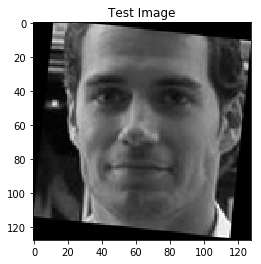

In [41]:
test_image = np.reshape(test_images[2], (1,height,width,1))
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title("Test Image")
plt.show()

### Layer 1

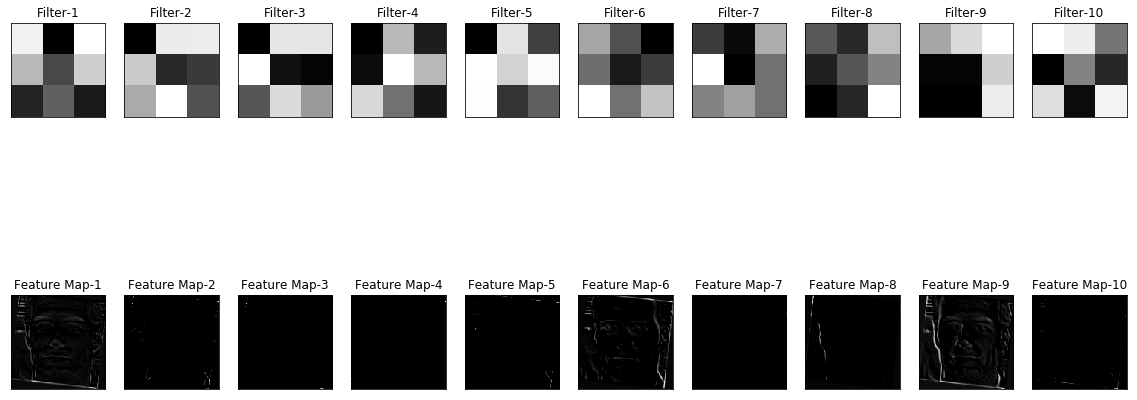

In [42]:
filter_weights = get_filters("Conv_1", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv1, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)

### Layer 2

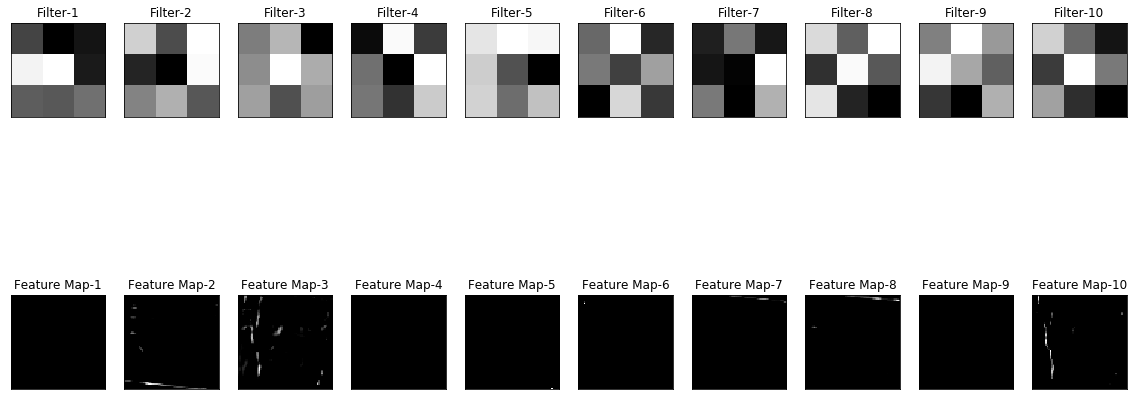

In [43]:
filter_weights = get_filters("Conv_2", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv2, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)

### Layer 3

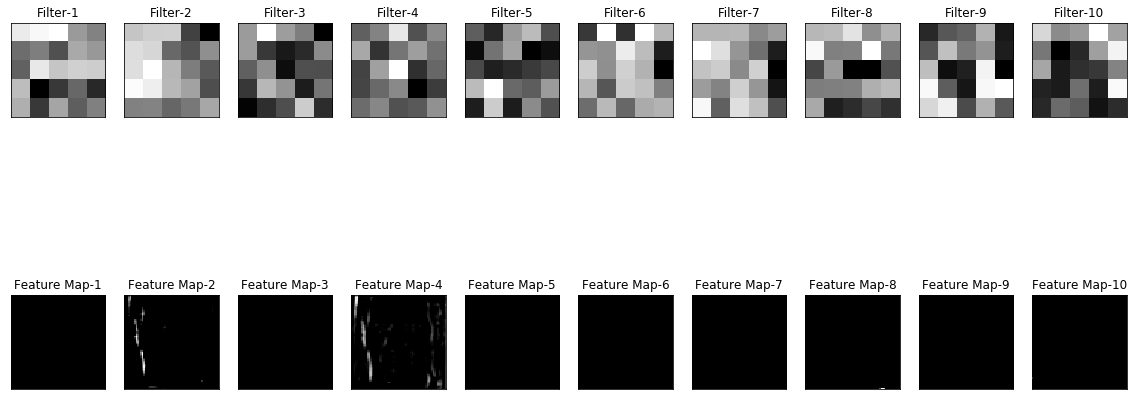

In [44]:
filter_weights = get_filters("Conv_3", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv3, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)

### Layer 4

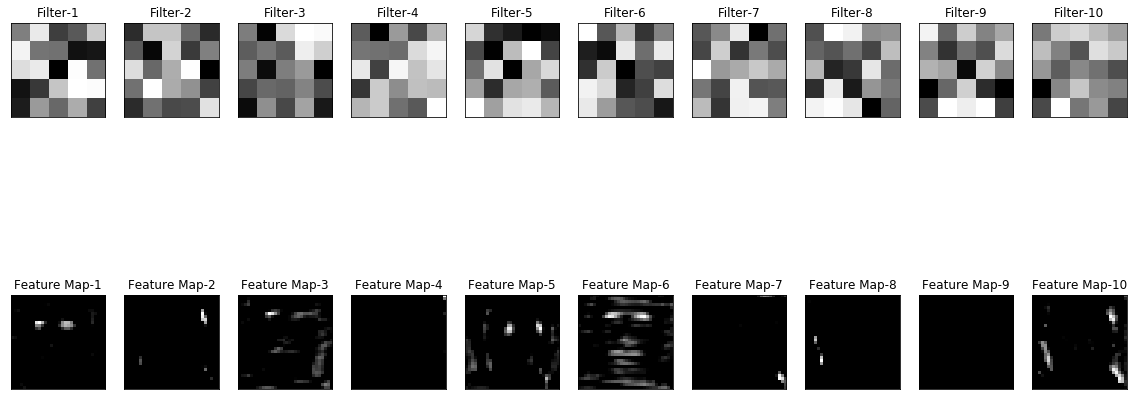

In [45]:
filter_weights = get_filters("Conv_4", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv4, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)

## Layer 5

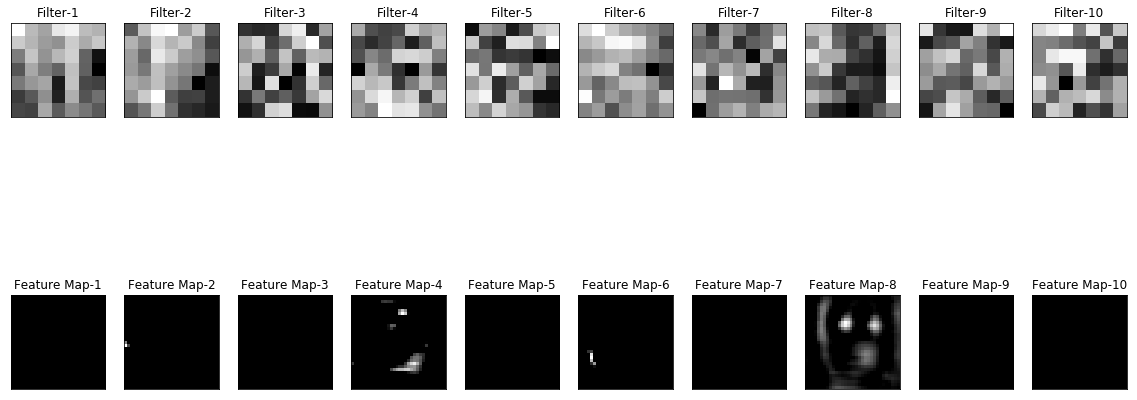

In [46]:
filter_weights = get_filters("Conv_5", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv5, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)

## Layer 6

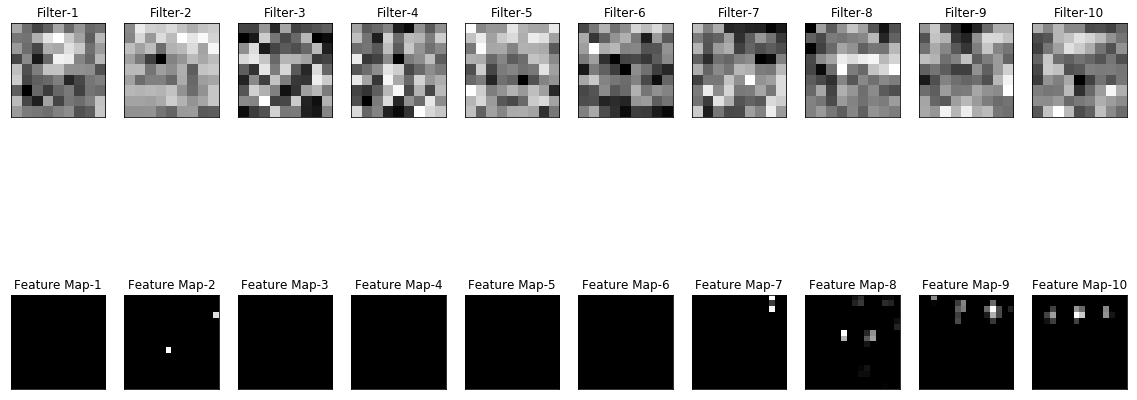

In [47]:
filter_weights = get_filters("Conv_6", test_image)
normalized_filters = (filter_weights-np.min(filter_weights)/(np.max(filter_weights)-np.min(filter_weights)))

feat_maps = get_feature_map(conv6, test_image)

plot_filter_featuremap(normalized_filters, feat_maps)